In [1]:
num_iters = 4000
env_num = 5
spec_num = 0
use_gpu = True

In [2]:
from conformal.all_paths_conformal_pred import all_paths_conformal_pred
from conformal.bucketed_conformal_pred import bucketed_conformal_pred
from conformal.nonconformity_score_graph import DIRLCumRewardScoreGraph, DIRLTimeTakenScoreGraph
from spectrl.hierarchy.construction import adj_list_from_task_graph, automaton_graph_from_spec
from spectrl.hierarchy.reachability import HierarchicalPolicy, ConstrainedEnv
from spectrl.main.spec_compiler import ev, seq, choose, alw
from spectrl.rl.ddpg.ddpg import DDPGParams
from spectrl.util.io import parse_command_line_options, save_log_info, save_object
from spectrl.util.rl import print_performance, get_rollout
from spectrl.rl.ars import HyperParams

from spectrl.examples.rooms_envs import (
    GRID_PARAMS_LIST,
    MAX_TIMESTEPS,
    START_ROOM,
    FINAL_ROOM,
)
from spectrl.envs.rooms import RoomsEnv

import os

In [3]:
render = False
folder = ''
itno = -1

log_info = []

grid_params = GRID_PARAMS_LIST[env_num]

# hyperparams = HyperParams(30, num_iters, 30, 15, 0.05, 0.3, 0.15)

print(
    "\n**** Learning Policy for Spec #{} in Env #{} ****".format(
        spec_num, env_num
    )
)

# Step 1: initialize system environment
system = RoomsEnv(grid_params, START_ROOM[env_num], FINAL_ROOM[env_num])

state_dim = system.observation_space.shape[0]
action_dim = system.action_space.shape[0]
action_bound = system.action_space.high
hyperparams = DDPGParams(state_dim, action_dim, action_bound,
                            minibatch_size=256, num_episodes=num_iters,
                            discount=0.95, actor_hidden_dim=256,
                            critic_hidden_dim=256, epsilon_decay=3e-6,
                            decay_function='linear', steps_per_update=100,
                            gradients_per_update=100, buffer_size=200000,
                            sigma=0.15, epsilon_min=0.3, target_noise=0.0003,
                            target_clip=0.003, warmup=1000)

# Step 4: List of specs.
if env_num == 2 or env_num == 5:
    bottomright = (0, 2)
    topleft = (2, 0)
if env_num == 3 or env_num == 4:
    bottomright = (0, 3)
    topleft = (3, 0)

spec0 = seq(
    choose(
        alw(grid_params.avoid_center_without_scaling((1, 0), 7.5), ev(grid_params.in_room_without_scaling(topleft))),
        alw(grid_params.avoid_center_without_scaling((0, 1), 10), ev(grid_params.in_room_without_scaling(bottomright)))
    ),
    ev(grid_params.in_room_without_scaling(FINAL_ROOM[env_num]))
)
spec1 = seq(
    alw(grid_params.avoid_center_without_scaling((1, 0), 7.5), ev(grid_params.in_room_without_scaling(topleft))),
    ev(grid_params.in_room_without_scaling(FINAL_ROOM[env_num]))
)
spec2 = alw(grid_params.avoid_center_without_scaling((1, 0), 7.5), ev(grid_params.in_room_without_scaling(topleft)))
spec3 = seq(
    ev(grid_params.in_room_without_scaling(bottomright)),
    ev(grid_params.in_room_without_scaling(FINAL_ROOM[env_num]))
)

specs = [spec0, spec1, spec2, spec3]

# Step 3: construct abstract reachability graph
_, abstract_reach = automaton_graph_from_spec(specs[spec_num])
print("\n**** Abstract Graph ****")
abstract_reach.pretty_print()

# Step 5: Learn policy
path_policies = abstract_reach.learn_all_paths(
    system,
    hyperparams,
    res_model=None,
    max_steps=40,
    render=render,
    neg_inf=-100,
    safety_penalty=-1,
    num_samples=500,
    use_gpu=use_gpu,
    algo="ddpg",
    alpha=0,
)

adj_list = adj_list_from_task_graph(abstract_reach.abstract_graph)
terminal_vertices = [i for i in range(len(adj_list)) if i in adj_list[i]]

import dill as pickle

with open("conformal_experiments_data/9rooms-counterexample-policies/path_policies.pkl", "wb") as f:
    pickle.dump(path_policies, f)

with open("conformal_experiments_data/9rooms-counterexample-policies/adj_list.pkl", "wb") as f:
    pickle.dump(adj_list, f)

with open("conformal_experiments_data/9rooms-counterexample-policies/terminal_vertices.pkl", "wb") as f:
    pickle.dump(terminal_vertices, f)



**** Learning Policy for Spec #0 in Env #5 ****

**** Abstract Graph ****
0 -> (land(('in_room((2, 0))', 'avoid_center((1, 0))')), 1) (land(('in_room((0, 2))', 'avoid_center((0, 1))')), 2)
1 -> (in_room((2, 2)), 3)
2 -> (in_room((2, 2)), 3)
3 -> (, 3)

Learning policy for edge 0 -> 1



/home/shabadi/dirl/venv/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Reward at episode 0: -844.7232963165694
Reward at episode 1: -752.8267558233638
Reward at episode 2: -691.3942325591528
Reward at episode 3: -779.0897296588412
Reward at episode 4: -763.6287065857043
Expected reward after 4 episodes: -925.2826753801173
Reward at episode 5: -692.3643446258013
Reward at episode 6: -836.7667439837461
Reward at episode 7: -775.5478707261475
Reward at episode 8: -746.0187807126148
Reward at episode 9: -810.7388759680168
Expected reward after 9 episodes: -925.2283528814584
Reward at episode 10: -683.4684650489772
Reward at episode 11: -803.0107805064312
Reward at episode 12: -811.1442059895915
Reward at episode 13: -821.6751873757809
Reward at episode 14: -848.6342116976492
Expected reward after 14 episodes: -922.6982249049418
Reward at episode 15: -763.8667571790338
Reward at episode 16: -748.5539246988855
Reward at episode 17: -821.0688804238592
Reward at episode 18: -755.7696876219685
Reward at episode 19: -673.7814027902971
Expected reward after 19 episo

/home/shabadi/dirl/venv/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(



Learning policy for edge 0 -> 2

Reward at episode 0: -736.7287023694867
Reward at episode 1: -799.0119515323089
Reward at episode 2: -743.7229824628076
Reward at episode 3: -835.4050637038508
Reward at episode 4: -746.7420770034657
Expected reward after 4 episodes: -639.9525262941737
Reward at episode 5: -912.9544222991532
Reward at episode 6: -716.0957825067649
Reward at episode 7: -770.0314248587755
Reward at episode 8: -809.7918890097102
Reward at episode 9: -721.369552830211
Expected reward after 9 episodes: -651.6939843059467
Reward at episode 10: -780.7481101801341
Reward at episode 11: -835.6874612930848
Reward at episode 12: -702.560009844948
Reward at episode 13: -813.9842415136375
Reward at episode 14: -742.7492833462543
Expected reward after 14 episodes: -645.3735235111865
Reward at episode 15: -791.0466490081595
Reward at episode 16: -780.5237859896396
Reward at episode 17: -759.8437291529666
Reward at episode 18: -745.7291293137306
Reward at episode 19: -752.390168925369

In [4]:
from conformal.all_paths_conformal_pred import all_paths_conformal_pred
from conformal.bucketed_conformal_pred import bucketed_conformal_pred
from conformal.calculate_coverage import calculate_coverage
from conformal.nonconformity_score_graph import DIRLCumRewardScoreGraph

import dill as pickle
import json

with open("conformal_experiments_data/9rooms-counterexample-policies/path_policies.pkl", "rb") as f:
    path_policies = pickle.load(f)

with open("conformal_experiments_data/9rooms-counterexample-policies/adj_list.pkl", "rb") as f:
    adj_list = pickle.load(f)

with open("conformal_experiments_data/9rooms-counterexample-policies/terminal_vertices.pkl", "rb") as f:
    terminal_vertices = pickle.load(f)

cum_reward_score_graph = DIRLCumRewardScoreGraph(adj_list, path_policies, cum_reward_type="cum_safety_reach_reward")
n_samples = 1000
n_samples_coverage = 1000
es = [0.1]
total_buckets = [100]

data_cum_reward = dict()
data_cum_reward["metadata"] = {"es": es, "total_buckets": total_buckets, "scores": "cum-reward", "env": "9-rooms", "spec": spec_num, "n_samples": n_samples}

for e in es:
    e_data = dict()
    for buckets in total_buckets:
        bucket_data = dict()
        vbs = bucketed_conformal_pred(cum_reward_score_graph, e, buckets, n_samples)
        min_path, min_path_scores = all_paths_conformal_pred(cum_reward_score_graph, e, n_samples)
        vb = vbs.buckets[(terminal_vertices[0], buckets)]

        bucket_data["bucketed"] = {"path": vb.path, 
                                   "path_buckets": vb.path_buckets, 
                                   "path_score_quantiles": vb.path_score_quantiles, 
                                   "max_path_score_quantile": max(vb.path_score_quantiles)}
        bucket_data["all-paths"] = {"path": min_path, "min_path_scores": min_path_scores, "max_min_path_scores": max(min_path_scores)}

        bucket_data["bucketed-coverage"] = calculate_coverage(
            cum_reward_score_graph, vb.path, vb.path_score_quantiles, n_samples_coverage
        )
        bucket_data["all-paths-coverage"] = calculate_coverage(
            cum_reward_score_graph, 
            min_path, 
            [max(min_path_scores) for _ in range(len(min_path)-1)], 
            n_samples_coverage,
        )
        e_data[buckets] = bucket_data
    data_cum_reward[str(e)] = e_data

# Convert the Python object to a JSON string
json_data = json.dumps(data_cum_reward, indent=2)

# Store the JSON string in a file
with open("conformal_experiments_data/9rooms-counterexample-cum-reward.json", "w") as json_file:
    json_file.write(json_data)


In [5]:
trajectories_scores1 = cum_reward_score_graph.sample_full_path_cached([0, 1, 3], n_samples)
trajectories_scores2 = cum_reward_score_graph.sample_full_path_cached([0, 2, 3], n_samples)

# trajectories_scores1 = cum_reward_score_graph.sample_full_path_cached([0, 1], n_samples)
# trajectories_scores2 = cum_reward_score_graph.sample_full_path_cached([0, 1], n_samples)

successful_trajs1, successful_trajs2 = 0, 0

for i in range(n_samples):
    if all(trajectories_scores1[i][j] <= 0 for j in range(2)):
        successful_trajs1 += 1
    if all(trajectories_scores2[i][j] <= 0 for j in range(2)):
        successful_trajs2 += 1

print("path 1 success prob " + str(successful_trajs1/n_samples))
print("path 2 success prob " + str(successful_trajs2/n_samples))

path 1 success prob 1.0
path 2 success prob 0.852


In [6]:
print(trajectories_scores1)

[[-0.1300447840660039, -9.234504920926453], [-0.11672638845952482, -9.287629447907984], [-0.20597419449522197, -9.497393683910582], [-0.1452995870965425, -9.476270929499949], [-0.12034200936858314, -9.471464417489981], [-0.14200942001065003, -9.145150051800643], [-0.10161507513925544, -9.532845786449668], [-0.13072063172720044, -8.82338482756652], [-0.14170828011125097, -9.441955184941728], [-0.1590971485419494, -9.143943762564446], [-0.17048679606256462, -8.740701397581764], [-0.15136819838478827, -8.940933000036344], [-0.13529494707179163, -9.196009650706005], [-0.2021979878814592, -9.248208607551886], [-0.2008516194891205, -8.887297269009823], [-0.1496736186131455, -9.475756866608803], [-0.15087910838756619, -9.183733092403335], [-0.12719073667082975, -8.741387384000754], [-0.15454370189291117, -9.136187726631187], [-0.1138430419532907, -9.546959303260051], [-0.16512012973664797, -9.47193527153995], [-0.13675004636023308, -9.072986716224674], [-0.20475078811991393, -8.82856302755836

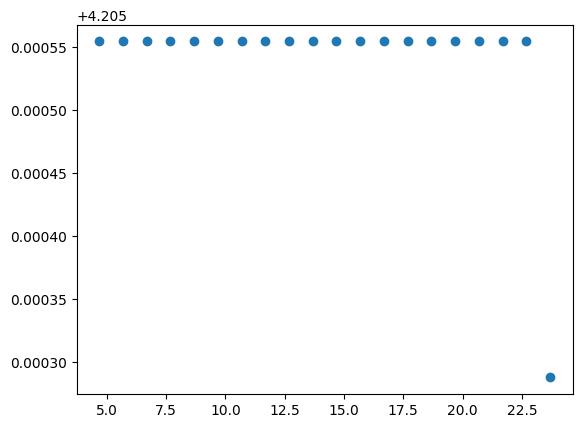

In [18]:
import matplotlib.pyplot as plt
import numpy as np

pp = cum_reward_score_graph.path_policies.get_vertex_path_policy([0])
sarss = get_rollout(
    pp.reach_envs[2],
    pp.policies[2],
    False,
    init_state=None
)
states = [state for state, _, _, _ in sarss] + [sarss[-1][-1]]
x_coords = [state[0] for state in states]
y_coords = [state[1] for state in states]

# Plot the points
plt.scatter(y_coords, x_coords)

[9.116677983114052, 8.116677983114052, 7.116677983114051, 6.116677983114051, 5.116677983114051, 4.116677983114051, 3.1166779831140508, 2.1166779831140508, 1.116677983114051, 0.11667798311405092, 0.48332201688594906, 1.4833220168859491, 2.483322016885949, 3.483322016885949, 4.483322016885949, 5.483322016885949, 6.483322016885949, 7.483322016885949, 8.48332201688595, 9.483321981210167]


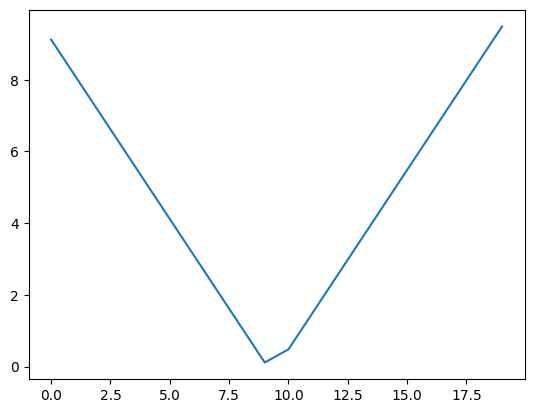

In [19]:
reach_env = pp.reach_envs[2]
safety_rewards = []
for s in states:
    safety_rewards.append(reach_env.constraints[0](s, None))

print(safety_rewards)
plt.plot(safety_rewards)